# Shapley Value Analysis For Lesioning

In [88]:
import numpy as np
import pandas as pd
import pickle, time, os, random
from tqdm import tqdm
import tensorflow as tf
import nilearn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy.matlib as matlib

import csv

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250

#from tensorflow import keras
#from tensorflow.keras import layers
#from functools import partial

In [2]:
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
# where the time_series is aligned to
aligned_to = 'play_end'

# length of time series
ts_length = 13

# read dataframe
data_df = pd.read_pickle(f"./data_df_play_times_aligned_to_{aligned_to}_ts_length_{ts_length}.pkl")
data_df

,subj,run,trial,time_series,trial_type,stimulus
0,600,1,1,"[[0.52923763305877, 0.4749125514767911, 1.6308...",low_reward,received
1,600,1,2,"[[-0.5130513669768391, -0.12752077135186823, 0...",high_threat,not received
2,600,1,3,"[[0.12495972500735775, 0.46859587371426414, 0....",low_reward,received
3,600,1,4,"[[1.244433440880485, -0.3960117860667083, -0.7...",low_reward,received
4,600,1,5,"[[-0.5506318924763463, 0.9748977664840197, 0.0...",high_reward,not received
...,...,...,...,...,...,...
1314,631,8,12,"[[-0.12096713026018335, -1.0052460978428996, 0...",high_threat,not received
1315,631,8,13,"[[-0.03315670862730258, -0.7638145582157421, 0...",high_reward,received
1316,631,8,14,"[[-0.22958929131419836, 0.07129877573336785, -...",high_reward,received
1317,631,8,15,"[[-0.12296967453092122, -0.22173471101338293, ...",high_reward,received


### target classes

In [4]:
target_classes=[('high_threat'), ('low_threat'), ('high_reward'), ('low_reward')]

### hyperparameters

In [5]:
class ARGS(): pass
args = ARGS()

args.num_subjects = pd.unique(data_df['subj']).shape[0]

args.num_train = round(0.75 * args.num_subjects)
#print(args.num_train)
args.num_test = args.num_subjects - args.num_train
#print(args.num_test)

args.num_units = 32
args.num_classes = len(target_classes)
args.l2 = 1e-2
args.dropout = 0.5
args.learning_rate = 1e-4

args.num_epochs = 150
args.validation_split = 0.2
args.batch_size = 32

args.SEED = 74

### dataset for classification

In [6]:
select_features = np.arange(85)

In [7]:
def get_dataset(data_df, subjs, target_classes, select_features):
    '''
    dataset for machine learning model
    input_samples (X): batch, time, features
    target_vectors (y): batch
    '''
    X = []
    y = []

    subj_data_df = data_df.loc[data_df['subj'].isin(subjs)]

    target_value = dict(zip(target_classes, 
                            list(np.arange(len(target_classes)))))

    for idx_row, row in tqdm(subj_data_df.iterrows()):
        #cond = (row['trial_type'], row['stimulus'])
        cond = (row['trial_type'])
        if cond not in target_classes:
            continue
        X.append(row['time_series'][:, select_features])
        y.append(target_value[cond])

    return np.stack(X, axis=0), np.stack(y, axis=0)

In [8]:
train_subjs = pd.unique(data_df['subj'])[:args.num_train]
test_subjs = pd.unique(data_df['subj'])[args.num_train:]

(X_train, 
 y_train) = get_dataset(data_df=data_df, subjs=train_subjs, target_classes=target_classes, select_features=select_features)
(X_test, 
 y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#print(X_test[0])

935it [00:00, 10594.48it/s]
384it [00:00, 12478.21it/s]

(935, 10, 85)
(935,)
(384, 10, 85)
(384,)


## Lesioning

In [9]:
model = tf.keras.models.load_model('model_GRU_4WayClasfn')

In [10]:
# extracting X_test, y_test again
(X_test, y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)

384it [00:00, 9393.63it/s]


In [ ]:
# define significance array
signif = np.ones((85,1000))

for roi in range(85):

    for it in range(1000):

        # select coalition size without current roi included
        coalsize = np.random.randint(85)

        # create coalition with elements between 0 and 85 with size 'coalsize'
        coal = np.random.randint(85,size=(1,coalsize))

        # remove the current roi from the coalition if already present due to randomization
        if roi in coal:
            coal = coal[coal != roi]

        # add the current roi to the coalition to create 'coalplus'
        coalplus = np.append(coal,roi)

        # mask 'coal' rois to create X_test_coal
        (X_test, y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)
        X_test_coal = X_test
        X_test_coal[:, :, coal] = 0.0

        # testing coal accuracy
        preds = model(X_test_coal)
        y_pred = np.argmax(preds, axis=1)
        acc_coal = np.sum(y_pred == y_test)/y_test.shape[0]

        # mask 'coalplus' rois to create X_test_coalplus
        (X_test, y_test) = get_dataset(data_df=data_df, subjs=test_subjs, target_classes=target_classes, select_features=select_features)
        X_test_coalplus = X_test
        X_test_coalplus[:, :, coalplus] = 0.0
        
        #testing coalplus accuracy
        preds = model(X_test_coalplus)
        y_pred = np.argmax(preds, axis=1)
        acc_coalplus = np.sum(y_pred == y_test)/y_test.shape[0]

        # calculating significance of current roi: more important means positive value: acc_coalplus will be smaller than acc_coal
        signif[roi,it] = acc_coal - acc_coalplus
        
print(signif)

In [ ]:
# saving significance array as the code was running for long
np.savetxt("signif.csv", signif, delimiter=",")

In [22]:
# opening csv file back into numpy array
file = open('signif.csv')
csvreader = csv.reader(file)
signif_list = []
for row in csvreader:
        signif_list.append(row)
file.close()

signif = np.array(signif_list,dtype=float)

In [48]:
# calculating mean significance of each roi across 1000 iterations
mean_signif = np.mean(signif,axis=1)

# generating the sorted order of rois in the ascending order of significance
roi_signif_order = np.argsort(mean_signif)

# reading roi names
file = open('ROI_Names.csv')
csvreader = csv.reader(file)
roi_list = []
for row in csvreader:
        roi_list.append(row)
file.close()
roi_arr = np.array(roi_list)

# creating array of roi names according to the significance order 
roi_signif = roi_arr[roi_signif_order]

In [56]:
mean_signif = np.expand_dims(mean_signif, axis=1)
#print(mean_signif.shape)

(85, 1)


In [69]:
# statistical analysis:
# genrating synthetic null distributions by subtracting average, thus centering the distribution around zero
syn_signif = signif - matlib.repmat(mean_signif, 1, 1000)

syn_dist = np.ones((85,1000))
CI_ub = np.ones(85)
CI_lb = np.ones(85)

# bootstrapping the synthetic distribution: average of 100 values, distribution of 1000 values
for roi in range(85):
    for bs_iter in range(1000):
        rand_samp = np.random.randint(1000,size=(1,100))
        syn_dist[roi,bs_iter] = np.mean(syn_signif[roi, rand_samp], axis=1)
    CI_ub[roi] = np.percentile(syn_dist[roi,:],97.5,axis=0)
    CI_lb[roi] = np.percentile(syn_dist[roi,:],2.5,axis=0)

In [82]:
# creating CI values for errorbars
CI_lb = np.abs(CI_lb)
CI_lb = np.expand_dims(CI_lb, axis=1)
CI_ub = np.expand_dims(CI_ub, axis=1)
CI = np.concatenate((CI_lb.T,CI_ub.T), axis=0)
CI = np.squeeze(CI)
#print(CI.shape)

(2, 85)


Text(0, 0.5, 'Shapley Value')

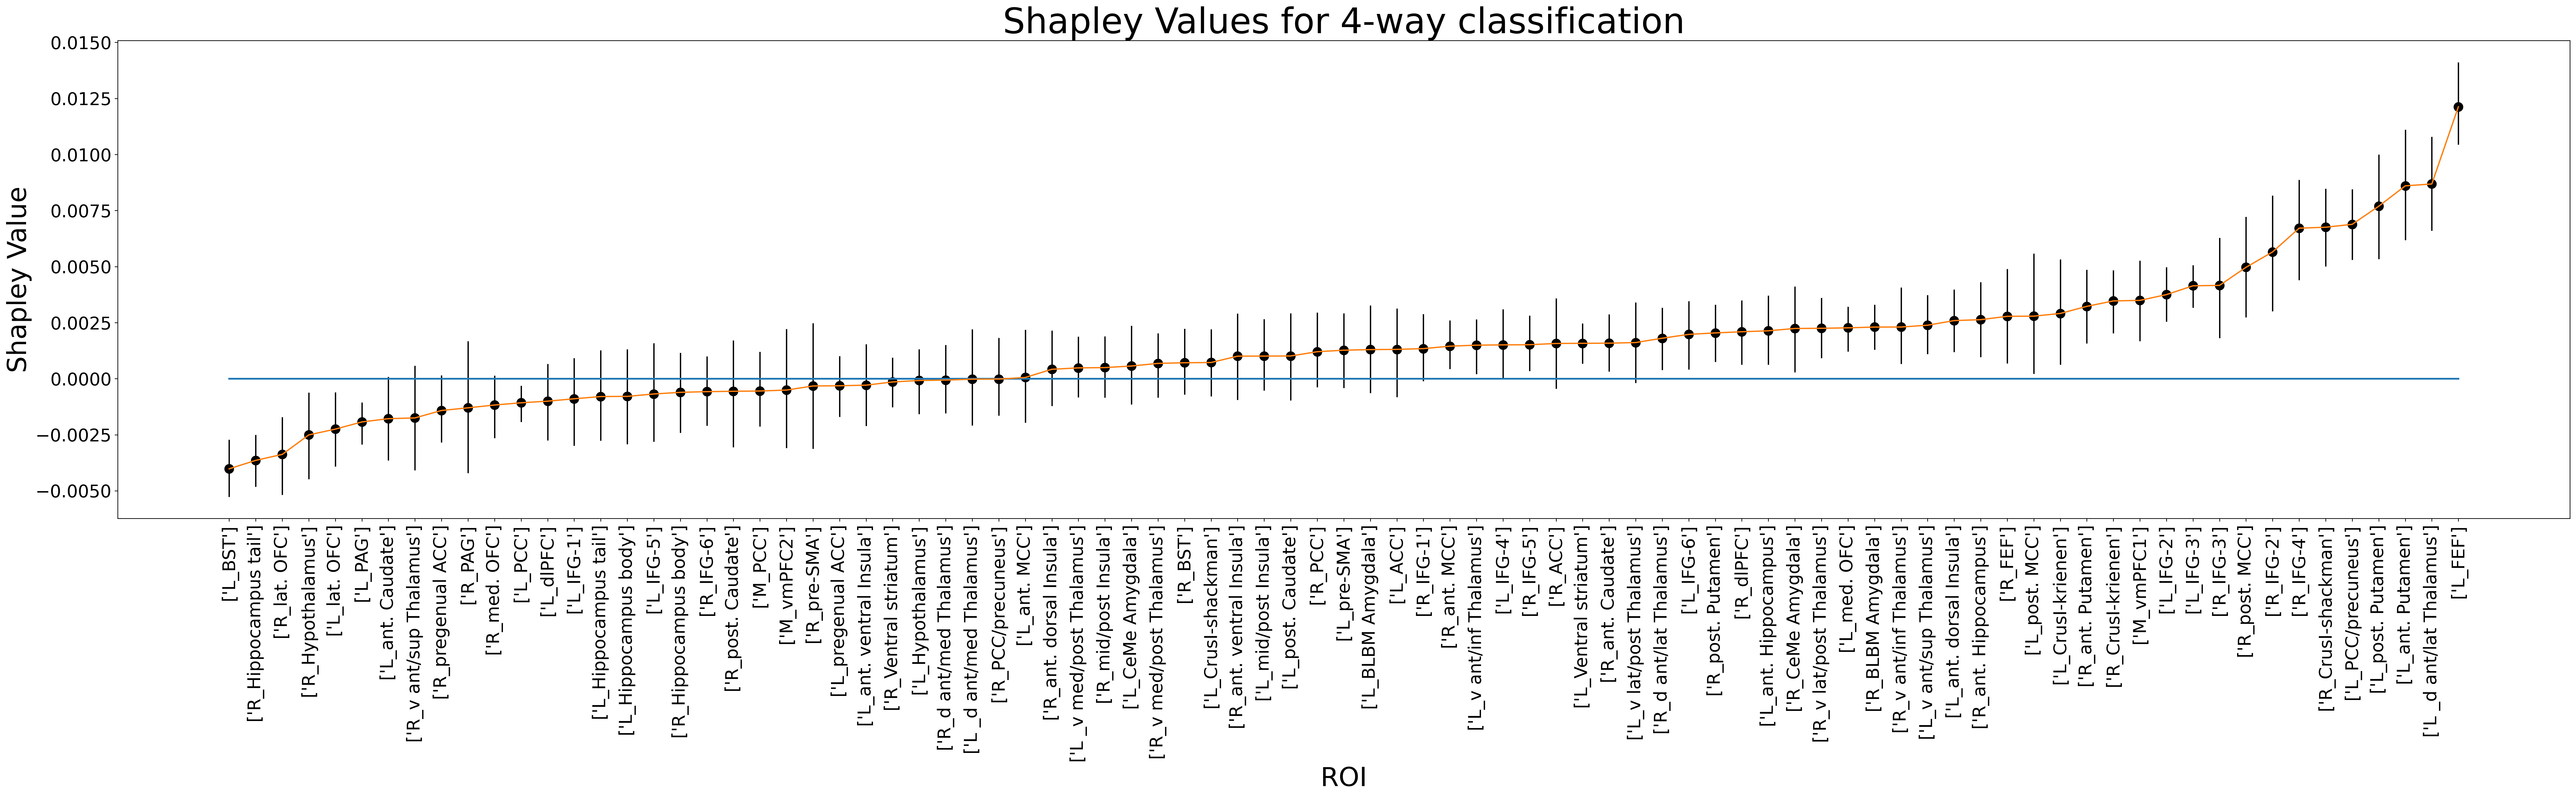

In [89]:
# plotting

plt.figure(figsize=(50,10))
plt.plot(np.arange(85),np.zeros(85),linewidth=2)
plt.scatter(range(85), np.squeeze(np.sort(mean_signif, axis=0)), s=100, color='#000000')
plt.errorbar(range(85), np.squeeze(np.sort(mean_signif, axis=0)), yerr=CI, ecolor='#000000')
plt.xticks(range(85), labels=roi_signif, rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title("Shapley Values for 4-way classification", fontsize=40)
plt.xlabel("ROI", fontsize=30)
plt.ylabel("Shapley Value", fontsize=30)
